이 자료는 2021년 12월 14일에 마지막으로 테스트되었습니다.

이 자료는 위키독스 '딥 러닝을 이용한 자연어 처리 입문'에서 BLEU 구현하기 튜토리얼입니다.  
링크 : https://wikidocs.net/31695

# 14-03 BLEU Score(Bilingual Evaluation Understudy Score)
---

앞서 언어 모델(Language Model)의 성능 측정을 위한 평가 방법으로 펄플렉서티(perplexity, PPL)를 소개한 바 있습니다. 기계 번역기에도 PPL을 평가에 사용할 수는 있지만, PPL은 번역의 성능을 직접적으로 반영하는 수치라 보기엔 어렵습니다.

자연어 처리에서는 그 외에도 수많은 평가 방법들이 존재하는데, 기계 번역의 성능이 얼마나 뛰어난가를 측정하기 위해 사용되는 대표적인 방법인 BLEU(Bilingual Evaluation Understudy) 대해서 학습해보겠습니다. 앞으로 진행되는 설명은 논문 BLEU: a Method for Automatic Evaluation of Machine Translation를 참고로 하여 작성되었습니다.

In [ ]:
import numpy as np
from collections import Counter
from nltk import ngrams

## 1. BLEU(Bilingual Evaluation Understudy)
BLEU는 기계 번역 결과와 사람이 직접 번역한 결과가 얼마나 유사한지 비교하여 번역에 대한 성능을 측정하는 방법입니다. 측정 기준은 n-gram에 기반합니다. n-gram의 정의는 언어 모델 챕터를 참고하시기 바랍니다.

BLEU는 완벽한 방법이라고는 할 수는 없지만 몇 가지 이점을 가집니다. 언어에 구애받지 않고 사용할 수 있으며, 계산 속도가 빠릅니다. BLEU는 PPL과는 달리 높을 수록 성능이 더 좋음을 의미합니다. BLEU를 이해하기 위해 기계 번역 성능 평가를 위한 몇 가지 직관적인 방법을 먼저 제시하고, 문제점을 보완해나가는 방식으로 설명합니다.

### 1) 단어 개수 카운트로 측정하기(Unigram Precision)
한국어-영어 번역기의 성능을 측정한다고 가정해봅시다. 두 개의 기계 번역기가 존재하고 두 기계 번역기에 같은 한국어 문장을 입력하여 번역된 영어 문장의 성능을 측정하고자 합니다. 번역된 문장을 각각 Candidate1, 2라고 해봅시다. 이 문장의 성능을 평가하기 위해서는 정답으로 비교되는 문장이 있어야 합니다. 세 명의 사람에게 한국어를 보고 영작해보라고 하여 세 개의 번역 문장을 만들어냈습니다. 이 세 문장을 각각 Reference1, 2, 3라고 해봅시다.

**Example 1**

* Candidate1 : It is a guide to action which ensures that the military always obeys the commands of the party.
* Candidate2 : It is to insure the troops forever hearing the activity guidebook that party direct.
* Reference1 : It is a guide to action that ensures that the military will forever heed Party commands.
* Reference2 : It is the guiding principle which guarantees the military forces always being under the command of the Party.
* Reference3 : It is the practical guide for the army always to heed the directions of the party.

편의상 Candidate를 Ca로, Reference를 Ref로 축약하여 부르겠습니다. Ca 1, 2를 Ref 1, 2, 3과 비교하여 성능을 측정하고자 합니다. 가장 직관적인 성능 평가 방법은 Ref 1, 2, 3 중 어느 한 문장이라도 등장한 단어의 개수를 Ca에서 세는 것입니다. 그리고 그 후에 Ca의 모든 단어의 카운트의 합. 즉, Ca에서의 총 단어의 수으로 나눠줍니다.

이러한 측정 방법을 **유니그램 정밀도(Unigram Precision)**라고 합니다. 이를 식으로 표현하면 다음과 같습니다.

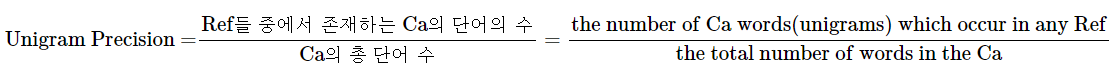

Ca1의 단어들은 얼추 훑어만봐도 Ref1, Ref2, Ref3에서 전반적으로 등장하는 반면, Ca2는 그렇지 않습니다. 이는 Ca1이 Ca2보다 더 좋은 번역 문장임을 의미합니다. 예를 들어 Ca1의 It is a guide to action은 Ref1에서, which는 Ref2에서, ensures that the militrary는 Ref1에서, always는 Ref2와 Ref3에서, commands는 Ref1에서, of the party는 Ref2에서 등장하였습니다. (대소문자 구분은 없다고 합시다.) Ca1에 있는 단어 중 Ref1, Ref2, Ref3 어디에도 등장하지 않은 단어는 obeys뿐입니다. 반면, Ca2는 Ca1과 비교하여 상대적으로 Ref1, 2, 3에 등장한 단어들이 적습니다.

위의 계산 방법에 따르면 Ca1과 Ca2의 유니그램 정밀도는 각각 아래와 같습니다.
  
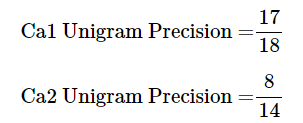

이제부터는 단어라는 표현보다는 유니그램이라는 용어로 설명하겠습니다. 지금까지 설명한 유니그램 정밀도는 나름 의미있는 측정 방법으로 보이지만 사실 허술한 점이 있습니다. 아래와 같은 새로운 예가 있다고 해봅시다.

### 2) 중복을 제거하여 보정하기(Modified Unigram Precision)

**Example 2**
* Candidate : the the the the the the the
* Reference1 : the cat is on the mat
* Reference2 : there is a cat on the mat

위의 Ca는 the만 7개가 등장한 터무니 없는 번역입니다. 하지만 이 번역은 앞서 배운 유니그램 정밀도에 따르면 
 
이라는 최고의 성능 평가를 받게 됩니다. 이에 유니그램 정밀도를 다소 보정할 필요를 느낍니다. 이를 보정하기 위해서는 정밀도의 분자를 계산하기 위해 Ref와 매칭하며 카운트하는 과정에서 Ca의 유니그램이 이미 Ref에서 매칭된 적이 있었는지를 고려해야 합니다.

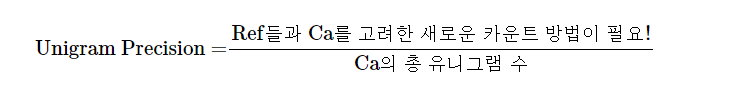

정밀도의 분자를 계산하기 위한 각 유니그램의 카운트는 다음과 같이 수정합시다. 우선, 유니그램이 하나의 Ref에서 최대 몇 번 등장했는지를 카운트합니다. 이 값을 maximum reference count를 줄인 의미에서 Max_Ref_Count라고 부르겠습니다. Max_Ref_Count가 기존의 단순 카운트한 값보다 작은 경우에는 이 값을 최종 카운트 값으로 대체합니다. 정밀도의 분자 계산을 위한 새로운 카운트 방식을 식으로 표현하면 다음과 같습니다.

$Count_{clip}\ =\ min(Count,\ {Max\_Ref\_Count})$

위의 카운트를 사용하여 분자를 계산한 정밀도를 **보정된 유니그램 정밀도(Modified Unigram Precision)**라고 합니다.

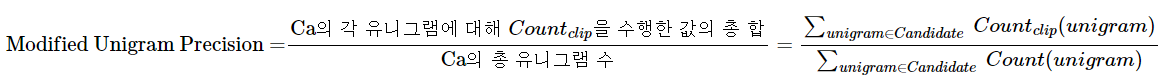


분모의 경우에는 이전과 동일하게 Ca의 모든 유니그램에 대해서 각각 하고 모두 합한 값을 사용합니다.

보정된 유니그램 정밀도를 예제를 통해 이해해봅시다. **Example 2**를 볼까요? the의 경우에는 Ref1에서 총 두 번 등장하였으므로, the의 카운트는 2로 보정됩니다. Ca의 기존 유니그램 정밀도는 $\frac{7}{7}=1$이었으나 보정된 유니그램 정밀도는 $\frac{2}{7}$와 같이 변경됩니다.

다른 예로 **Example 1**에서의 Ca1의 보정된 유니그램 정밀도를 계산해보면 보정되기 이전과 동일하게 $\frac{17}{18}$이지만 결과를 얻는 과정은 다릅니다. Ca1에서 the는 3번 등장하지만, Re2와 Ref3에서 the가 4번 등장하므로 3이 4보다 작으므로 the는 3으로 카운트 됩니다. the 외에 Ca1의 모든 유니그램은 전부 1개씩 등장하므로 보정 전과 동일하게 카운트하면 됩니다. 결과적으로 보정 이전의 정밀도와 동일하게 $\frac{17}{18}$의 값을 가집니다.

### 3) 보정된 유니그램 정밀도 (Modified Unigram Precision) 구현하기

보정된 유니그램 정밀도를 파이썬 함수로 구현해보겠습니다. 보정된 유니그램 정밀도를 구현하기 위해서는 유니그램을 카운트 하는  $Count$ 함수와  $Count_{clip}$ 함수 두 가지 함수를 구현해야 합니다. 분모를 구하기 위해서 $Count$ 함수를 사용하고, 분자를 구하기 위해서 $Count_{clip}$ 함수를 사용하면 보정된 유니그램 정밀도를 구할 수 있습니다. 우선 유니그램을 단순히 $Count$하는 함수를 simple_count라는 이름의 아래 함수로 구현합니다.

In [ ]:
# 토큰화 된 문장(tokens)에서 n-gram을 카운트
def simple_count(tokens, n):
  return Counter(ngrams(tokens, n))

위 함수는 토큰화 된 문장을 입력받아서 문장 내의 n-gram의 개수를 카운트하는 함수입니다. 구하고자 하는 것은 유니그램 정밀도이므로 카운트하고자 하는 n-gram의 단위를 결정하는 simple_count 함수의 두번째 인자인 n의 값을 1로 하여 함수를 실행하면 됩니다. **Example 1**의 Ca1를 가져와 함수가 어떤 결과를 출력하는지 확인해봅시다.

In [ ]:
candidate = "It is a guide to action which ensures that the military always obeys the commands of the party."
tokens = candidate.split() # 토큰화
result = simple_count(tokens, 1) # n = 1은 유니그램
print('유니그램 카운트 :',result)

유니그램 카운트 : Counter({('the',): 3, ('It',): 1, ('is',): 1, ('a',): 1, ('guide',): 1, ('to',): 1, ('action',): 1, ('which',): 1, ('ensures',): 1, ('that',): 1, ('military',): 1, ('always',): 1, ('obeys',): 1, ('commands',): 1, ('of',): 1, ('party.',): 1})


In [ ]:
candidate = 'the the the the the the the'
tokens = candidate.split() # 토큰화
result = simple_count(tokens, 1) # n = 1은 유니그램
print('유니그램 카운트 :',result)

유니그램 카운트 : Counter({('the',): 7})


simple_count 함수는 단순 카운트를 수행하므로 the에 대해서 7이라는 카운트 값을 리턴합니다. $Count$에 대한 함수를 구현하였으니 이번에는 $Count_{clip}$을 아래의 count_clip 이름을 가진 함수로 구현해보겠습니다.

In [ ]:
def count_clip(candidate, reference_list, n):
  # Ca 문장에서 n-gram 카운트
  ca_cnt = simple_count(candidate, n)
  max_ref_cnt_dict = dict()

  for ref in reference_list: 
    # Ref 문장에서 n-gram 카운트
    ref_cnt = simple_count(ref, n)
    
    # 각 Ref 문장에 대해서 비교하여 n-gram의 최대 등장 횟수를 계산.
    for n_gram in ref_cnt: 
      if n_gram in max_ref_cnt_dict:
        max_ref_cnt_dict[n_gram] = max(ref_cnt[n_gram], max_ref_cnt_dict[n_gram])
      else:
        max_ref_cnt_dict[n_gram] = ref_cnt[n_gram]

  return {
        # count_clip = min(count, max_ref_count)
        n_gram: min(ca_cnt.get(n_gram, 0), max_ref_cnt_dict.get(n_gram, 0)) for n_gram in ca_cnt
     }

count_clip 함수는 candidate 문장과 reference 문장들, 그리고 카운트 단위가 되는 n-gram에서의 n의 값 이 세 가지를 인자로 입력받아서 $count_{clip}$을 수행합니다. 여기서는 유니그램 정밀도를 구현하고 있으므로 역시나 n=1로 하여 함수를 실행하면 됩니다.

또한 count_clip 함수 내부에는 기존에 구현했던 simple_count 함수가 사용된 것을 확인할 수 있습니다. $Count_{clip}$을 구하기 위해서는 $Max\_Ref\_Count$값과 비교하기 위해 $Count$값이 필요하기 때문입니다. **Example 2**를 통해 함수가 정상 작동되는지 확인해봅시다.

In [ ]:
candidate = 'the the the the the the the'
references = [
    'the cat is on the mat',
    'there is a cat on the mat'
]
result = count_clip(candidate.split(),list(map(lambda ref: ref.split(), references)),1)
print('보정된 유니그램 카운트 :',result)

보정된 유니그램 카운트 : {('the',): 2}


동일한 예제 문장에 대해서 위의 simple_count 함수는 the가 7개로 카운트되었던 것과는 달리 이번에는 2개로 카운트되었습니다. 위의 두 함수를 사용하여 예제 문장에 대해서 보정된 정밀도를 연산하는 함수를 modified_precision란 이름의 함수로 구현해봅시다.

In [ ]:
def modified_precision(candidate, reference_list, n):
  clip_cnt = count_clip(candidate, reference_list, n) 
  total_clip_cnt = sum(clip_cnt.values()) # 분자

  cnt = simple_count(candidate, n)
  total_cnt = sum(cnt.values()) # 분모

  # 분모가 0이 되는 것을 방지
  if total_cnt == 0: 
    total_cnt = 1

  # 분자 : count_clip의 합, 분모 : 단순 count의 합 ==> 보정된 정밀도
  return (total_clip_cnt / total_cnt)

In [ ]:
result = modified_precision(candidate.split(), list(map(lambda ref: ref.split(), references)), n=1)
print('보정된 유니그램 정밀도 :',result)

보정된 유니그램 정밀도 : 0.2857142857142857


소수 값이 나오는데 이는 $\frac{2}{7}$의 값을 의미합니다. 이는 앞서 육안으로 계산했던 **Example 2**에서 Ca의 보정된 정밀도와 동일합니다. 지금까지 보정된 유니그램 정밀도에 대해서 설명하고, 직접 구현까지 해보았습니다.

이제부터 설명에서 언급하는 '정밀도'는 기본적으로 **보정된 정밀도(Modified Precision)**라고 가정합니다. 정밀도를 보정하므로서 Ca에서 발생하는 단어 중복에 대한 문제점은 해결되었습니다. 하지만 유니그램 정밀도가 가지는 본질적인 문제점이 있기에 유니그램을 넘어 바이그램, 트라이그램 등과 같이 n-gram으로 확장해야 합니다. 문제점이 무엇인지 이해하고, 어떻게 n-gram으로 확장하는지 학습해봅시다.

---
### 4) 순서를 고려하기 위해서 n-gram으로 확장하기
BoW 표현과 유사하게, 유니그램 정밀도와 같이 각 단어의 빈도수로 접근하는 방법은 결국 단어의 순서를 고려하지 않는다는 특징이 있습니다. **Example 1**에 Ca3이라는 새로운 문장을 추가해보고 기존의 Ca1과 비교해봅시다.

**Example 1**
* Candidate1 : It is a guide to action which ensures that the military always obeys the commands of the party.
* Candidate2 : It is to insure the troops forever hearing the activity guidebook that party direct.
* __Candidate3 : the that military a is It guide ensures which to commands the of action obeys always party the.__
* Reference1 : It is a guide to action that ensures that the military will forever heed Party commands.
* Reference2 : It is the guiding principle which guarantees the military forces always being under the command of the Party.
* Reference3 : It is the practical guide for the army always to heed the directions of the party.  
  

Ca3은 사실 Ca1에서 모든 유니그램의 순서를 랜덤으로 섞은 실제 영어 문법에 맞지 않은 문장입니다. 하지만 Ref 1, 2, 3과 비교하여 유니그램 정밀도를 적용하면 Ca1과 Ca3의 두 정밀도는 동일합니다. 유니그램 정밀도는 유니그램의 순서를 전혀 고려하지 않기 때문입니다. 이를 위한 대안으로 개별적인 유니그램/단어로서 카운트하는 유니그램 정밀도에서 다음에 등장한 단어까지 함께 고려하여 카운트하도록 유니그램 외에도 Bigram, Trigram, 4-gram 단위 등으로 계산한 정밀도. 즉, n-gram을 이용한 정밀도를 도입하고자 합니다.

이들 각각은 카운트 단위를 2개, 3개, 4개로 보느냐의 차이로 2-gram Precision, 3-gram Precision, 4-gram Precision이라고 하기도 합니다. 어떤 의미인지 바이그램(Bigram) 단위로 카운트하여 **Example 1, 2**의 바이그램 정밀도(Bigram Precision)를 계산해보겠습니다. 우선 좀 더 쉬운 **Example 2**부터 볼까요?

**Example 2**
* Candidate1 : the the the the the the the
* Candidate2 : the cat the cat on the mat
* Reference1 : the cat is on the mat
* Reference2 : there is a cat on the mat
이해를 돕고자 Example 2에 Ca2를 새로 추가했습니다. Ca2 바이그램의 $Count$와 $Count_{clip}$은 아래와 같습니다.

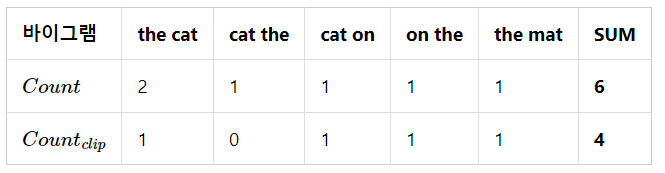
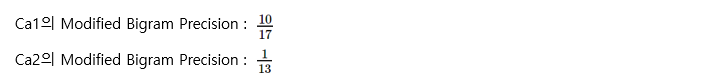

결과적으로 Ca2의 바이그램 정밀도는 $\frac{4}{6}$가 됩니다. 반면, 당연하게도 Ca1의 바이그램 정밀도는 0입니다. Example 1은 어떨까요? Example 1에서 Ca1의 바이그램 정밀도는 $\frac{10}{17}$이며, Ca2의 바이그램 정밀도는 $\frac{1}{13}$입니다. Ca1에서 단어의 순서를 뒤섞은 Ca3의 바이그램 정밀도는 독자분들의 숙제로 남깁니다.

보정된 정밀도를 식으로 정의해보겠습니다. $p_n$에서 $n$은 n-gram에서의 $n$을 의미한다고 하였을 때, 앞서 배운 보정된 유니그램 정밀도의 식을 상기해봅시다.

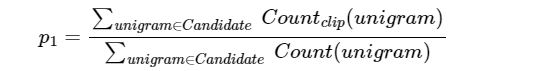

이를 n-gram으로 일반화하면 아래와 같습니다.

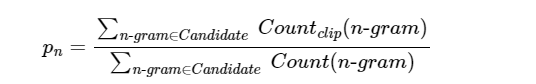





유니그램 정밀도에서는 $n$이 1이므로 $p_1$로 표현하였으나, 일반화 된 식에서는 $p_n$으로 표현한 것을 볼 수 있습니다.

여기서는 보정된 바이그램 정밀도 $p_2$, 보정된 트라이그램 정밀도 $p_3$ 등에 대한 파이썬 실습은 생략합니다. 사실 $p_n$을 계산하기 위한 함수를 별도로 다시 구현할 필요는 없는데, 앞서 구현한 함수 simple_count, count_clip, modified_precision은 모두 n-gram의 n을 함수의 인자로 받으므로, n을 1대신 다른 값을 넣어서 실습해보면 바이그램, 트라이그램 등에 대해서도 보정된 정밀도를 구할 수 있습니다.

n-gram 정밀도 식을 이해하였다면 BLEU의 최종 식까지 다 왔습니다. BLEU는 보정된 정밀도 $p_1, p_2, ... p_n$를 모두 조합하여 사용합니다. 이를 모두 조합한 BLEU의 식은 아래와 같습니다.

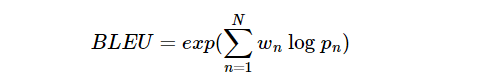

$p_n$ : 각 gram의 보정된 정밀도입니다.  
$N$ : n-gram에서 $n$의 최대 숫자입니다. 보통은 4의 값을 가집니다. $N$이 4라는 것은 $p_1, p_2, p_3, p_4$를 사용한다는 것을 의미합니다.  
$w_n$ : 각 gram의 보정된 정밀도에 서로 다른 가중치를 줄 수 있습니다. 이 가중치의 합은 1로 합니다. 예를 들어 $N$이 4라고 하였을 때, $p_1, p_2, p_3, p_4$에 대해서 동일한 가중치를 주고자한다면 모두 0.25를 적용할 수 있습니다.

BLEU의 최종식에 거의 다 도달했습니다. 즉, 여전히 위의 BLEU식에도 문제점이 존재합니다.

### 5) 짧은 문장 길이에 대한 패널티(Brevity Penalty)
n-gram으로 단어의 순서를 고려한다고 하더라도 여전히 남아있는 문제가 있는데, 바로 Ca의 길이에 BLEU의 점수가 과한 영향을 받을 수 있다는 점입니다. 기존 **Example 1**에 다음의 Ca를 추가한다고 해보겠습니다.

**Example 1**  
  
**Candidate4 : it is**
  
이 문장은 유니그램 정밀도나 바이그램 정밀도가 각각 $\frac{2}{2}$, $\frac{1}{1}$로 두 정밀도 모두 1이라는 높은 정밀도를 얻습니다. 이과 같이 제대로 된 번역이 아님에도 문장의 길이가 짧다는 이유로 높은 점수를 받는 것은 이상합니다. 그래서 *Ca가 Ref보다 문장의 길이가 짧은 경우에는 점수에 패널티*를 줄 필요가 있습니다. 이를 **브레버티 패널티(Brevity Penalty)**라고 합니다. (직역하면 짧음 패널티) 이에 대해서 배우기 전에, 만약 반대로 Ca의 길이가 Ref보다 긴 경우에도 문제가 생길 수 있는지 보겠습니다.

**Example 3**
* Candidate 1: I always invariably perpetually do.
* Candidate 2: I always do.
* Reference 1: I always do.
* Reference 2: I invariably do.
* Reference 3: I perpetually do.
**Example 3**에서 Ca1은 가장 많은 단어를 사용했지만 Ca2보다 좋지 못한 번역입니다. 다시 말해 Ref의 단어를 가장 많이 사용한 것이 꼭 좋은 번역이라는 의미는 아닙니다. 그런데 다행히도 위와 같이 Ca의 길이가 불필요하게 Ref보다 긴 경우에는 BLEU 수식에서 정밀도를 n-gram으로 확장하여 바이그램, 트라이그램 정밀도 등을 모두 계산에 사용하고 있는 것만으로도 이미 패널티를 받고 있습니다. 즉, 브레버티 패널티를 설계할 때, 이 경우까지 고려할 필요는 없습니다.

다시 Ref보다 Ca의 길이가 짧을 경우에 패널티를 주는 브레버티 패널티의 이야기로 돌아보겠습니다. 브레버티 패널티는 앞서 배운 BLEU의 식에 곱하는 방식으로 사용합니다. 브레버티 패널티를 줄여서 $BP$라고 하였을 때, 최종 BLEU의 식은 아래와 같습니다.  
  
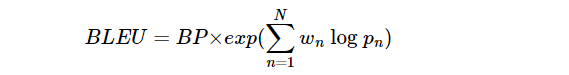

위의 수식은 패널티를 줄 필요가 없는 경우에는 $BP$의 값이 1이어야 함을 의미합니다. 이를 반영한 $BP$의 수식은 아래와 같습니다.
  
  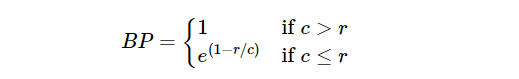

 $c$: Candidate의 길이  
 $r$ : Candidate와 가장 길이 차이가 작은 Reference의 길이
    


      
Ref가 1개라면 Ca와 Ref의 두 문장의 길이만을 가지고 계산하면 되겠지만 여기서는 Ref가 여러 개일 때를 가정하고 있으므로  $r$은 모든 Ref들 중에서 Ca와 가장 길이 차이가 작은 Ref의 길이로 합니다.  $r$을 구하는 코드는 아래와 같습니다.

In [ ]:
# Ca 길이와 가장 근접한 Ref의 길이를 리턴하는 함수
def closest_ref_length(candidate, reference_list):
  ca_len = len(candidate) # ca 길이
  ref_lens = (len(ref) for ref in reference_list) # Ref들의 길이
  # 길이 차이를 최소화하는 Ref를 찾아서 Ref의 길이를 리턴
  closest_ref_len = min(ref_lens, key=lambda ref_len: (abs(ref_len - ca_len), ref_len))
  return closest_ref_len

만약 Ca와 길이가 정확히 동일한 Ref가 있다면 길이 차이가 0인 최고 수준의 매치(best match length)입니다. 또한 만약 서로 다른 길이의 Ref이지만 Ca와 길이 차이가 동일한 경우에는 더 작은 길이의 Ref를 택합니다. 예를 들어 Ca가 길이가 10인데, Ref 1, 2가 각각 9와 11이라면 길이 차이는 동일하게 1밖에 나지 않지만 9를 택합니다. closest_ref_length 함수를 통해 $r$을 구했다면, $BP$를 구하는 함수 brevity_penalty를 구현해봅시다.

In [ ]:
def brevity_penalty(candidate, reference_list):
  ca_len = len(candidate)
  ref_len = closest_ref_length(candidate, reference_list)

  if ca_len > ref_len:
    return 1

  # candidate가 비어있다면 BP = 0 → BLEU = 0.0
  elif ca_len == 0 :
    return 0
  else:
    return np.exp(1 - ref_len/ca_len)

위 함수는 앞서 배운 $BP$의 수식처럼 $c$가 $r$보다 클 경우에는 1을 리턴하고, 그 외의 경우에는 $e^{1-r/c}$를 리턴합니다. 최종적으로 BLEU 점수를 계산하는 함수 bleu_score를 구현해봅시다.

In [ ]:
def bleu_score(candidate, reference_list, weights=[0.25, 0.25, 0.25, 0.25]):
  bp = brevity_penalty(candidate, reference_list) # 브레버티 패널티, BP

  p_n = [modified_precision(candidate, reference_list, n=n) for n, _ in enumerate(weights,start=1)] 
  # p1, p2, p3, ..., pn
  score = np.sum([w_i * np.log(p_i) if p_i != 0 else 0 for w_i, p_i in zip(weights, p_n)])
  return bp * np.exp(score)

위의 bleu_score 함수는 기본적으로는 $N$이 4에 각 gram에 대한 가중치는 동일하게 0.25라 주어진다고 가정합니다. 또한 함수 내에서는 $BP$를 구하고 bp에, $p_1, p_2, ..., p_n$를 구하여 p_n에 저장하도록 구현되어져 있습니다. 그리고 앞서 배운 BLEU의 식에 따라 추가 연산하여 최종 계산한 값을 리턴합니다.

위 함수가 동작하기 위해서는 앞서 구현한 simple_count, count_clip, modified_precision, brevity_penalty 4개의 함수 또한 모두 구현되어져 있어야 합니다. 지금까지 구현한 BLEU 코드로 계산된 점수와 NLTK 패키지에 이미 구현되어져 있는 BLEU 코드로 계산된 점수를 비교해봅시다.

---
## 2. NLTK를 사용한 BLEU 측정하기

파이썬에서는 NLTK 패키지를 사용하여 BLEU를 계산할 수 있습니다.

In [ ]:
import nltk.translate.bleu_score as bleu

candidate = 'It is a guide to action which ensures that the military always obeys the commands of the party'
references = [
    'It is a guide to action that ensures that the military will forever heed Party commands',
    'It is the guiding principle which guarantees the military forces always being under the command of the Party',
    'It is the practical guide for the army always to heed the directions of the party'
]

print('실습 코드의 BLEU :',bleu_score(candidate.split(),list(map(lambda ref: ref.split(), references))))
print('패키지 NLTK의 BLEU :',bleu.sentence_bleu(list(map(lambda ref: ref.split(), references)),candidate.split()))

실습 코드의 BLEU : 0.5045666840058485
패키지 NLTK의 BLEU : 0.5045666840058485
